In [1]:
%load_ext autoreload

In [2]:
%autoreload 
import h2o
from h2o.estimators import *
from h2o.grid import *

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21); OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)
  Starting server from /Users/henrik/anaconda3/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1d/b_59w_9j0kx4nzfn4hkp84lc0000gn/T/tmpf6fj7pmx
  JVM stdout: /var/folders/1d/b_59w_9j0kx4nzfn4hkp84lc0000gn/T/tmpf6fj7pmx/h2o_henrik_started_from_python.out
  JVM stderr: /var/folders/1d/b_59w_9j0kx4nzfn4hkp84lc0000gn/T/tmpf6fj7pmx/h2o_henrik_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,"7 days, 23 hours and 2 minutes"
H2O_cluster_name:,H2O_from_python_henrik_64zm0d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Load FE data


In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [5]:
X_train = pd.read_csv('X_train_selected.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test_selected.csv')

In [6]:
# set date_foercast as index
X_train.set_index('date_forecast', inplace=True)
y_train.set_index('date_forecast', inplace=True)

In [7]:
db = pd.concat([X_train, y_train], axis=1)
# remove duplicate columns
db = db.loc[:,~db.columns.duplicated()]

In [8]:
db_h20 = h2o.H2OFrame(db)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [9]:
db_h20["pv_measurement"].describe()

Rows:84798
Cols:1

,pv_measurement
type,real
mins,0.0
mean,273.4150678812036
maxs,5651.8
sigma,754.4522917671936
zeros,46232
missing,0
0,570.1125
1,570.1125
2,570.1125


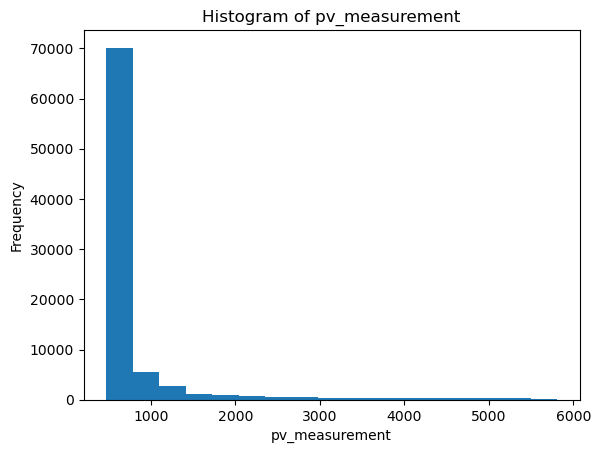

breaks,counts,mids_true,mids,widths
313.989,nan,nan,nan,nan
627.978,70129,0,470.983,313.989
941.967,5470,157.3,784.972,313.989
1255.96,2788,314.38,1098.96,313.989
1569.94,1085,471.24,1412.95,313.989
1883.93,842,627.99,1726.94,313.989
2197.92,672,785.51,2040.93,313.989
2511.91,562,942.81,2354.92,313.989
2825.9,497,1099.01,2668.91,313.989
3139.89,376,1260.05,2982.89,313.989


In [10]:
db_h20["pv_measurement"].hist()

In [11]:
train, valid, test = db_h20.split_frame([0.70, 0.15], seed = 42)
print("train:%d valid:%d test:%d" % (train.nrows, valid.nrows, test.nrows))

train:59346 valid:12656 test:12796


In [12]:
y = "pv_measurement"

x = list(db_h20.columns)
x.remove(y)

## Basic XGBoost model

In [49]:
xgb = H2OXGBoostEstimator(seed = 42, 
                          model_id = 'XGBoost', 
                          nfolds = 0, 
                          keep_cross_validation_predictions = False)

%time xgb.train(x = x, y = y, training_frame = train, validation_frame = valid)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
CPU times: user 95.8 ms, sys: 30.1 ms, total: 126 ms
Wall time: 7.91 s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 40325.29495789261
RMSE: 200.8115906960866
MAE: 74.56087502895096
RMSLE: NaN
Mean Residual Deviance: 40325.29495789261

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 64431.513072300615
RMSE: 253.83363266576913
MAE: 92.27191120836866
RMSLE: NaN
Mean Residual Deviance: 64431.513072300615

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2023-10-11 09:23:54  0.622 sec   0.0                807.5795151920194   276.1396754629506   652184.673357777     808.2589355599363   279.5166051095421   653282.5069124813
     2023-10-11 09:23:55  1.470 sec   1.0                603.7264807585344   198.6967041898062   364485.663569085     601.8819242994509   200.23496129470743  362261.85079840996
     2023-10-11 09:23:56  1.728 sec   2.0                469.8630506608505   152.42772019987632  220771.28637632093   467.7493289145816   153.99980737563806  218789.43470004146
     2023-10-11 09:23:56  1.888 sec   3.0                384.85134288019515  126.89811945739974  148110.55611668952   382.1614018186652   128.35168024218981  146047.3370400073
     2023-10-11 09:23:56  2.027 sec   4.0                332.5096499971094   112.3952671784733   110562.66734120023   330.30695382137714  113.54795670845427  109102.68374275738
     2023-10-11 09:23:56  2.182 sec   5.0                301.4698356568204   104.00772306833163  90884.0618109503     300.73053353868505  105.6367749043672   90438.85380246217
     2023-10-11 09:23:56  2.334 sec   6.0                281.2992000440972   98.3035529416195    79129.239945449      282.9741386226322   100.79109994378871  80074.36312922068
     2023-10-11 09:23:56  2.452 sec   7.0                270.1329743355282   94.76386927953598   72971.82382335915    273.09445269504056  97.90442136548255   74580.58009280374
     2023-10-11 09:23:56  2.581 sec   8.0                263.31436466423406  92.31620643454318   69334.45463852923    268.024133127414    96.18300707834007   71836.93593870175
     2023-10-11 09:23:56  2.707 sec   9.0                257.26713980499414  89.9690784359058    66186.3812234424     263.6640311839309   94.48559247283501   69518.72134016089
---  ---                  ---         ---                ---                 ---                 ---                  ---                 ---                 ---
     2023-10-11 09:23:58  4.003 sec   20.0               233.5928537971944   83.23591530297769   54565.62134511744    257.8391572630641   92.37089273107459   66481.0310181271
     2023-10-11 09:23:58  4.137 sec   21.0               231.39830322893738  82.60609351205562   53545.174737231246   257.317017327564    92.24626691559419   66212.04740635387
     2023-10-11 09:23:58  4.246 sec   22.0               230.50999221544757  82.3643024759061    53134.85651116569    257.39073942426296  92.29883946312236   66249.99274136884
     2023-10-11 09:23:58  4.406 sec   23.0               228.88513040821383  82.05122502544344   52388.40292198505    257.15026841851346  92.53641031735886   66126.26054771352
     2023-10-11 09:23:58  4.530 sec   24.0               227.10406025870282  81.58703459568514   51576.25418598852    257.02901475915957  92.54574563696188   66063.91442806428
     2023-10-11 09:23:58  4.663 sec   25.0               226.33313543456404  81.3889147201422    51226.68819564071    256.92215989413853  92.52767822590589   66008.9962446693
     2023-10-11 09:23:59  4.800 sec   26.0               224.68286578981088  80.91232909824073   50482.39017952217    

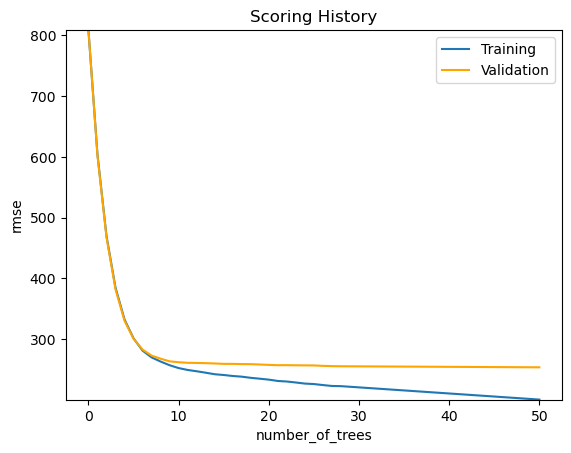

In [50]:
xgb.plot()

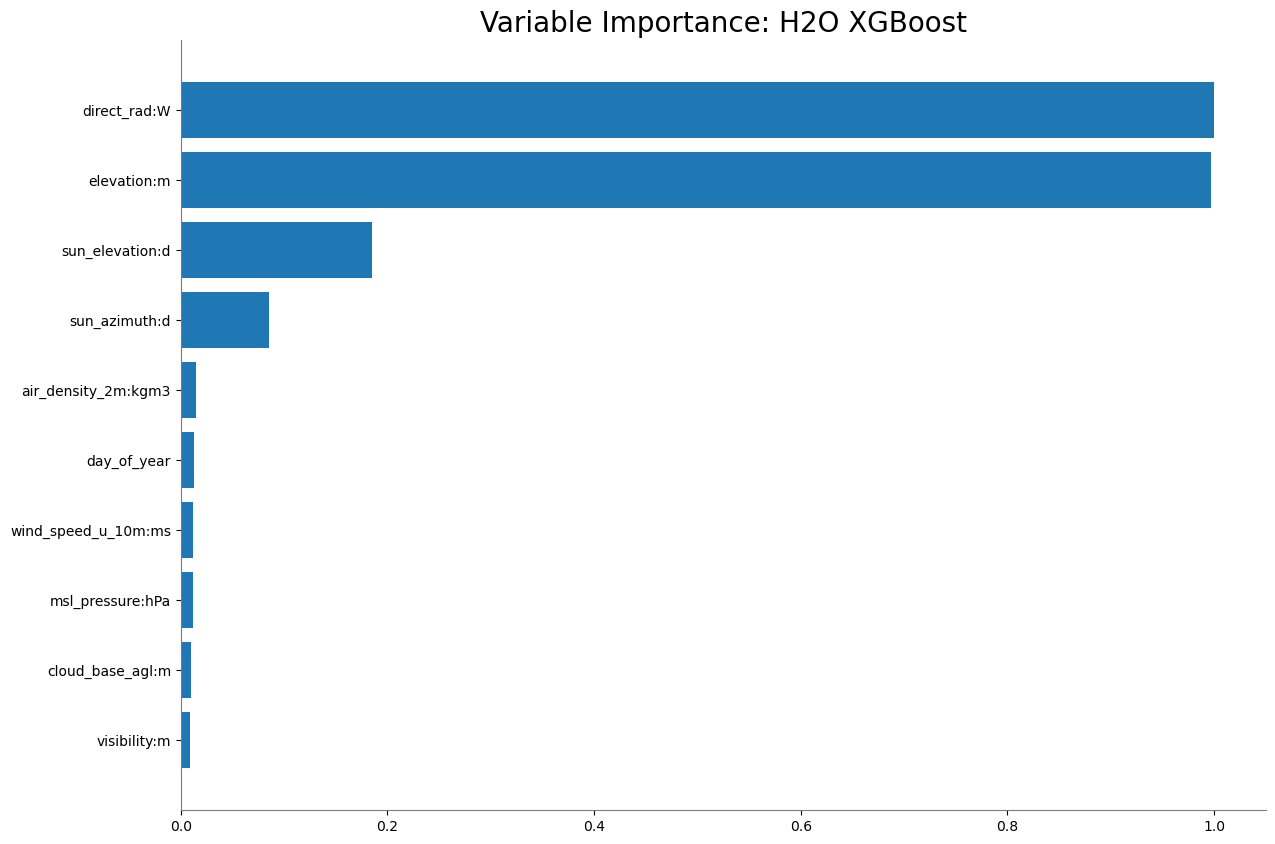

<Figure size 640x480 with 0 Axes>

In [51]:
xgb.varimp_plot()

In [52]:
xgb_def_pred = xgb.predict(valid)
xgb_def_pred.cbind(valid['pv_measurement'])

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


predict,pv_measurement
2363.1,1311.42
220.82,234.6
208.663,162.15
28.5707,0
214.172,50.38
3.57438,0
-9.32473,0
67.1654,0
117.501,202.688
145.776,123.338


In [53]:
default_xgb_per = xgb.model_performance(valid)

## Deepl learning model

In [54]:
dl = H2ODeepLearningEstimator(seed = 42, 
                              model_id = 'DL',
                              nfolds = 0,
                              keep_cross_validation_predictions = False)

%time dl.train(x = x, y = y, training_frame = train, validation_frame = valid)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
CPU times: user 216 ms, sys: 59.8 ms, total: 276 ms
Wall time: 19.3 s


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DL


Status of Neuron Layers: predicting pv_measurement, regression, gaussian distribution, Quadratic loss, 44,801 weights/biases, 537.1 KB, 593,460 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight            weight_rms           mean_bias             bias_rms
--  -------  -------  ---------  ---------  ----  ----  ---------------------  ---------------------  ----------  ---------------------  -------------------  --------------------  -----------------------
    1        21       Input      0.0
    2        200      Rectifier  0.0        0.0   0.0   0.00765357799259142    0.01699255406856537    0.0         0.020154727659109563   0.16184759140014648  0.4913038516306408    0.2802450656890869
    3        200      Rectifier  0.0        0.0   0.0   0.09431720707872955    0.13324850797653198    0.0         -0.032490476101808594  0.09253638982772827  0.9389554262523245    0.0532829612493515
    4        1        Linear                0.0   0.0   0.0012333416125329677  0.0010151355527341366  0.0         0.031386282374587605   0.09280869364738464  -0.11491506461729252  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 102739.05853985438
RMSE: 320.5293411528099
MAE: 128.1890428805247
RMSLE: NaN
Mean Residual Deviance: 102739.05853985438

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 107006.26032616015
RMSE: 327.1181137237132
MAE: 133.24516583562226
RMSLE: NaN
Mean Residual Deviance: 107006.26032616015

Scoring History: 
    timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2023-10-11 09:27:40  0.000 sec                     0         0             0          nan              nan                  nan             nan            nan                nan                    nan               nan
    2023-10-11 09:27:48  9.057 sec   7580 obs/sec      1         1             59346      541.369          293081               232.936         0.477401       543.893            295819                 238.845           0.485939
    2023-10-11 09:27:54  14.617 sec  27181 obs/sec     6         6             356076     439.646          193289               174.52          0.655343       451.984            204290                 181.879           0.644995
    2023-10-11 09:27:58  18.823 sec  34811 obs/sec     10        10            593460     320.529          102739               128.189         0.816804       327.118            107006                 133.245           0.81405

Variable Importances: 
variable                     relative_importance    scaled_importance    percentage
---------------------------  ---------------------  -------------------  --------------------
elevation:m                  1.0                    1.0                  0.20647691574312077
sun_azimuth:d                0.3980012834072113     0.3980012834072113   0.0821780774597247
fresh_snow_1h:cm             0.2766836881637573     0.2766836881637573   0.05712879456848403
fresh_snow_6h:cm             0.23285923898220062    0.23285923898220062  0.04808005746733506
sun_elevation:d              0.23193536698818207    0.23193536698818207  0.047889299227468665
direct_rad:W                 0.22566168010234833    0.22566168010234833  0.04659392770894365
day_of_year                  0.22078000009059906    0.22078000009059906  0.04558597347647282
fresh_snow_24h:cm            0.219365194439888      0.219365194

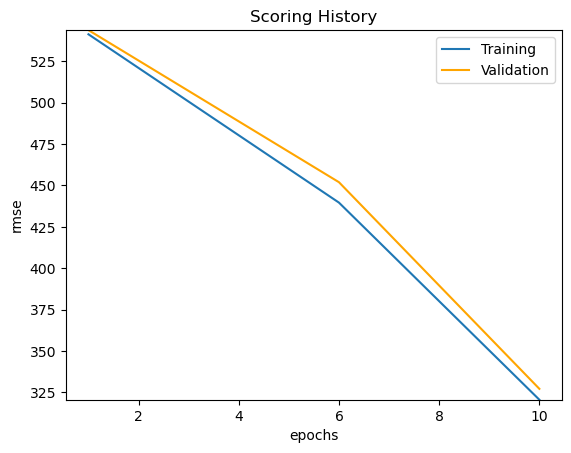

In [55]:
dl.plot()

In [56]:
print("epochs = ", dl.params['epochs'])

epochs =  {'default': 10.0, 'actual': 10.0, 'input': 10.0}


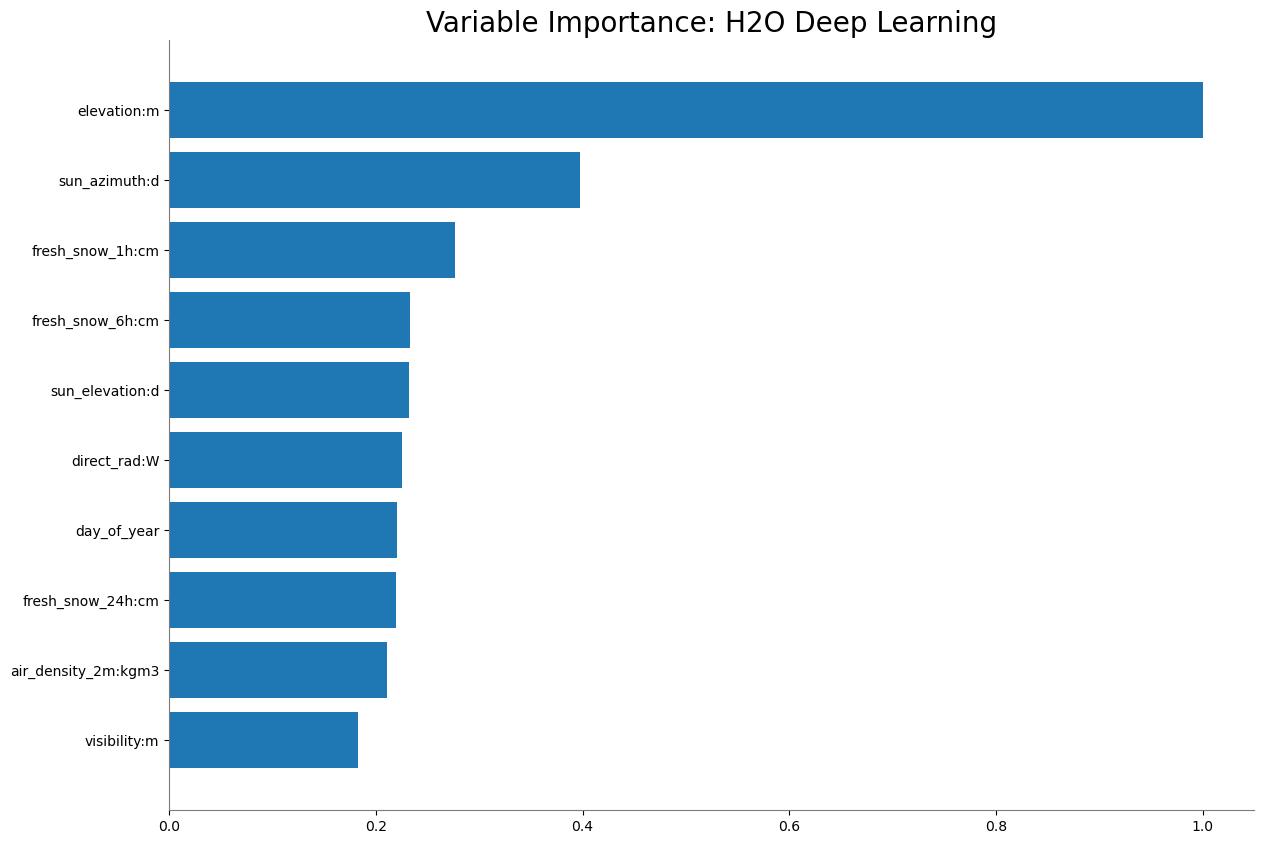

<Figure size 640x480 with 0 Axes>

In [57]:
dl.varimp_plot()

In [58]:
default_dl_per = dl.model_performance(valid)

## Tune XGBoost with H2O GridSearch

We will first try to find the max_depth for our XGBoost, as this is one of the most important parameters for an XGBoost model.

max_depth defines the number of nodes along the longest path from the start of the tree to the farthest leaf node. By default, the value is 6. We could do a random search along with the other parameters, but when max_depth is large, the model takes longer to train; therefore, in order to do a more efficient random search with the other parameters, we will first find the best value max_depth, and we will use 100 trees with early stopping to tune our hyper-parameters.

In [13]:
xgb = H2OXGBoostEstimator(model_id = 'xgb', 
                          ntrees = 300,
                          stopping_rounds = 3, #default
                          stopping_tolerance = 1e-3, #default
                          stopping_metric = "rmse", #default
                          seed = 42)

hyper_params = {'max_depth' : [5,7,9,10,12,13,15,20]}

grid_id = 'max_depth_grid'

search_criteria = { "strategy":"Cartesian"}

xgb_grid = H2OGridSearch(model = xgb, 
                         hyper_params = hyper_params,
                         grid_id = grid_id,
                         search_criteria = search_criteria)

%time xgb_grid.train(x = x, y = y, training_frame = train, validation_frame = valid)

xgboost Grid Build progress: |█ (cancelled)
Errors/Warnings building gridsearch model

Hyper-parameter: max_depth, 5
failure_details: Job Canceled
failure_stack_traces: java.lang.RuntimeException: Error while training XGBoost model
	at hex.tree.xgboost.XGBoost$XGBoostDriver.buildModel(XGBoost.java:429)
	at hex.tree.xgboost.XGBoost$XGBoostDriver.computeImpl(XGBoost.java:379)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:253)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1689)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:976)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1479)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)
Caused by: water.Job$JobCancelledException
	at hex.tree.xgboost.XGBoost$XGBoostDriver.scoreAndBuildTrees(XGBoost.java:494)
	at hex.tree.xgboost.XGBoost$XGBoostDriver.buildModel(XGBoost.java:427)
	.

ValueError: Job Canceled


In [18]:
sorted_xgb = xgb_grid.get_grid(sort_by = 'mae', decreasing = False)
sorted_xgb.sorted_metric_table()

,,max_depth,model_ids,mae
0,,12.0,max_depth_grid_model_5,22.992198
1,,20.0,max_depth_grid_model_8,23.172042
2,,15.0,max_depth_grid_model_7,23.430561
3,,13.0,max_depth_grid_model_6,24.080828
4,,10.0,max_depth_grid_model_4,25.026697
5,,9.0,max_depth_grid_model_3,27.831295
6,,7.0,max_depth_grid_model_2,43.378806
7,,5.0,max_depth_grid_model_1,68.886511


We will use four values for max_depth based on the results from the previous grid search to try to tune the next parameters. We will set ntrees=500 while using early stopping, the same way we did in the first self-paced course and we will try to tune the following three parameters:

1. sample_rate: Specifies the row sampling ratio of the training instance (x-axis). (Note that this method is sample without replacement.) For example, setting this value to 0.5 tells XGBoost to randomly collecte half of the data instances to grow trees. This value defaults to 1, and the range is 0.0 to 1.0. Higher values may improve training accuracy. Test accuracy improves when either columns or rows are sampled.

2. col_sample_rate: Specifies the column sampling rate (y-axis) for each split in each level. (Note that this method is sample without replacement.) This value defaults to 1.0, and the range is 0.0 to 1.0

3. col_sample_rate_per_tree: Specifies the column subsampling rate per tree. (Note that this method is sample without replacement.) This value defaults to 1.0 and can be a value from 0.0 to 1.0

Since we have 4 parameters in this grid search, we will be doing a random search; we will be using early stopping, and for our stopping criteria, we will set a limit of 100 models or 15 minutes. You can change these settings in the search_criteria_tune parameter for the grid search.

In [15]:
xgb = H2OXGBoostEstimator(model_id = 'xgb_grid', 
                          ntrees = 500, 
                          learn_rate = 0.05,
                          stopping_rounds = 3, #default
                          stopping_tolerance = 1e-3, #default
                          stopping_metric = "mae",
                          seed = 42)

hyper_params = {'eta' : [0.01, 0.05, 0.1, 0.2, 0.3],
                'max_depth' : [12,20,15,13,10],
                'sample_rate': [x/100. for x in range(20,101)],
                'col_sample_rate' : [x/100. for x in range(20,101)],
                'col_sample_rate_per_tree': [x/100. for x in range(20,101)]}

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 7200, # 2 hours  
                        'max_models': 200,  ## build no more than 100 models
                        'seed' : 42}

xgb_grid = H2OGridSearch(xgb, hyper_params,
                         grid_id = 'random_grid',
                         search_criteria = search_criteria_tune)

%time xgb_grid.train(x = x, y = y, training_frame = train, validation_frame = valid)

xgboost Grid Build progress: |██████████████████████████████████████████████████ (cancelled)  99%


In [64]:
sorted_xgb = xgb_grid.get_grid(sort_by = 'mae', decreasing = False)
sorted_xgb.sorted_metric_table()

,,col_sample_rate,col_sample_rate_per_tree,max_depth,sample_rate,model_ids,mae
0,,0.68,1.00,12.0,0.91,random_grid_model_80,83.021436
1,,0.70,0.99,10.0,0.86,random_grid_model_52,87.886035
2,,0.46,0.97,12.0,0.69,random_grid_model_46,90.437133
3,,0.73,0.91,7.0,0.93,random_grid_model_120,90.726307
4,,0.77,0.96,12.0,0.72,random_grid_model_99,90.778137
...,...,...,...,...,...,...,...
124,,0.93,0.27,12.0,0.61,random_grid_model_42,272.855811
125,,0.26,0.26,12.0,0.55,random_grid_model_20,274.126725
126,,0.90,0.22,10.0,0.46,random_grid_model_32,274.808602
127,,0.91,0.24,13.0,0.37,random_grid_model_56,282.065496


In [65]:
best_xgb_model = xgb_grid.models[0] 
best_xgb_model

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: random_grid_model_52


Model Summary: 
    number_of_trees
--  -----------------
    129

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 1304.9257634308499
RMSE: 36.12375621984582
MAE: 17.370878251049618
RMSLE: NaN
Mean Residual Deviance: 1304.9257634308499

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 60126.05499392486
RMSE: 245.20614795295174
MAE: 87.8860350405911
RMSLE: NaN
Mean Residual Deviance: 60126.05499392486

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2023-10-11 09:40:12  1 min  3.403 sec  0.0                807.5795151920194   276.1396754629506   652184.673357777     808.2589355599363   279.5166051095421   653282.5069124813
     2023-10-11 09:40:12  1 min  3.592 sec  1.0                631.7694796456819   210.82758848613332  399132.67541177577   633.7741022176401   212.97826891565842  401669.6126417758
     2023-10-11 09:40:12  1 min  3.707 sec  2.0                503.37649637542563  164.38847366188554  253387.89710319892   511.495079789875    168.2667967526886   261627.21664925056
     2023-10-11 09:40:13  1 min  3.829 sec  3.0                439.1731767667442   137.7359203279312   192873.07919139392   458.6599163648371   144.62908882413686  210368.91887979934
     2023-10-11 09:40:13  1 min  3.954 sec  4.0                360.85300924054997  113.62262226591015  130214.89427796045   387.19726506155183  124.02678992250445  149921.72207114563
     2023-10-11 09:40:13  1 min  4.087 sec  5.0                304.69193035548653  97.5030217778881    92837.17242375265    339.1510035617961   111.16247258388334  115023.40321697341
     2023-10-11 09:40:13  1 min  4.246 sec  6.0                265.076944392222    86.29492227774693   70265.78644831714    307.31430861432864  103.28107947747675  94442.08427910284
     2023-10-11 09:40:13  1 min  4.416 sec  7.0                235.4653311458931   77.93028477685911   55443.922171645085   287.3093003231801   98.24775558002621   82546.63405219528
     2023-10-11 09:40:13  1 min  4.583 sec  8.0                213.64309837050916  71.62293974297314   45643.37348135106    275.08494311456843  95.40644172227795   75671.72592834535
     2023-10-11 09:40:14  1 min  4.749 sec  9.0                198.04283561528695  67.21370034232508   39220.96473854357    266.8853994435267   93.16196881745917   71227.81643613079
---  ---                  ---               ---                ---                 ---                 ---                  ---                 ---                 ---
     2023-10-11 09:40:15  1 min  6.097 sec  16.0               146.3826115937362   51.50461056439045   21427.86897700263    251.61107099488515  88.12211290391411   63308.131047193136
     2023-10-11 09:40:15  1 min  6.306 sec  17.0               142.2878966674304   50.387167984583186  20245.845538041354   251.09540469170892  87.94045180577241   63048.902257293084
     2023-10-11 09:40:15  1 min  6.500 sec  18.0               138.88149571598302  49.33007459759229   19288.06985230861    250.8048039617885   87.7771022221507    62903.04969031116
     2023-10-11 09:40:15  1 min  6.706 sec  19.0               135.91797718856589  48.51159036081915   18473.696523031515   250.23862052165765  87.57004245736503   62619.367200582186
     2023-10-11 09:40:16  1 min  6.949 sec  20.0               133.13961830875243  47.67840442538468   17726.15796340029    249.79027307105093  87.50315986418265   62395.18052091019
     2023-10-11 09:40:16  1 min  7.146 sec  21.0               130.20026158002173  46.84009733301227   16952.108115506082   249.67880370428256  87.42779794455578   62

In [68]:
tuned_xgb_per = best_xgb_model.model_performance(valid)

In [69]:
print("Default XGB MAE: %.4f \nTuned XGB MAE:%.4f" % (default_xgb_per.mae(), tuned_xgb_per.mae()))

Default XGB MAE: 92.2719 
Tuned XGB MAE:87.8860


## Tune the Deep Learning model with H2O GridSearch

## Test Set Performance

In [70]:
xgb_test_per = best_xgb_model.model_performance(test)

In [71]:
print("XGBoost Test MAE: %.4f " % 
      (xgb_test_per.mae()))

XGBoost Test MAE: 86.4200 


In [75]:
X_test_h2O = h2o.H2OFrame(X_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [77]:
result_xgb = best_xgb_model.predict(X_test_h2O)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [78]:
result_xgb_df = result_xgb.as_data_frame()

In [82]:
# merge with X_test to get date_forecast
result_xgb_df = pd.concat([X_test, result_xgb_df], axis=1)

In [88]:
import numpy as np

In [89]:
# remove all negative values
result_xgb_df['pv_measurement'] = np.where(result_xgb_df['predict'] < 0, 0, result_xgb_df['predict'])

In [97]:
# set date_forecast as index
result_xgb_df.set_index('date_forecast', inplace=True)

KeyError: "None of ['date_forecast'] are in the columns"

In [98]:
result_xgb_df

,direct_rad:W,elevation:m,sun_elevation:d,sun_azimuth:d,day_of_year,air_density_2m:kgm3,wind_speed_u_10m:ms,msl_pressure:hPa,cloud_base_agl:m,ceiling_height_agl:m,...,relative_humidity_1000hPa:p,wind_speed_v_10m:ms,effective_cloud_cover:p,day_of_month,fresh_snow_24h:cm,day_of_week,fresh_snow_6h:cm,fresh_snow_1h:cm,predict,pv_measurement
date_forecast,,,,,,,,,,,,,,,,,,,,,
2023-05-01 00:00:00,0.0,6.0,-11.185,10.520,121,1.286,2.2,1013.9,1041.2,912.7,...,80.3,3.4,80.7,1,0.0,0,0.0,0.0,25.310625,25.310625
2023-05-01 00:00:00,0.0,7.0,-11.184,10.521,121,1.283,2.2,1014.0,1039.9,912.3,...,80.3,3.4,80.7,1,0.0,0,0.0,0.0,27.403830,27.403830
2023-05-01 00:00:00,0.0,24.0,-11.223,10.519,121,1.286,1.5,1014.0,1178.0,NaN,...,81.1,3.1,73.7,1,0.0,0,0.0,0.0,3.209401,3.209401
2023-05-01 00:15:00,0.0,6.0,-10.825,14.203,121,1.287,2.1,1013.7,1054.8,912.7,...,80.3,3.4,77.0,1,0.0,0,0.0,0.0,25.310625,25.310625
2023-05-01 00:15:00,0.0,7.0,-10.824,14.204,121,1.283,2.1,1013.8,1053.1,912.3,...,80.3,3.4,77.1,1,0.0,0,0.0,0.0,27.403830,27.403830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 23:30:00,0.0,6.0,-3.541,2.253,184,1.208,1.6,993.6,1405.5,2015.6,...,83.2,-1.1,100.0,3,0.0,0,0.0,0.0,-84.938148,0.000000
2023-07-03 23:30:00,0.0,7.0,-3.540,2.253,184,1.207,1.6,993.6,1408.6,2015.0,...,83.1,-1.1,100.0,3,0.0,0,0.0,0.0,-10.855761,0.000000
2023-07-03 23:45:00,0.0,7.0,-3.423,5.719,184,1.207,1.6,993.7,1343.6,2014.9,...,83.5,-1.1,100.0,3,0.0,0,0.0,0.0,-10.691576,0.000000


In [101]:
# change index data type to datetime
result_xgb_df.index = pd.to_datetime(result_xgb_df.index)

In [103]:
result = result_xgb_df[result_xgb_df.index.minute == 0]

In [105]:
import utilities as ut

In [108]:
# rename pv_measurement to pv_prediction
result.rename(columns={'pv_measurement': 'pv_prediction'}, inplace=True)

/var/folders/1d/b_59w_9j0kx4nzfn4hkp84lc0000gn/T/ipykernel_1605/3524025629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.rename(columns={'pv_measurement': 'pv_prediction'}, inplace=True)


In [109]:
ut.save_to_csv(result, 'result_h2o_xgb')